In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(4)
numpyro.set_platform('gpu') # set it to cpu and increase the number of devices if required

In [2]:
import jax.numpy as jnp 
from jax.tree_util import tree_flatten, tree_map, tree_reduce
from leaguedata.data import get_history_dict, get_tier_sorted

history = get_history_dict()
min_length = tree_reduce(min, tree_map(lambda x: len(x), history))
history_array, _ = tree_flatten(tree_map(lambda x: x[-min_length:], history))
history_array = jnp.asarray(history_array)

Generating train split:   0%|          | 0/2997254 [00:00<?, ? examples/s]

In [18]:
import pickle
import arviz as az
import operator
import jax.numpy as jnp 
import numpy as np
from jax.tree_util import tree_flatten, tree_map, tree_reduce
from leaguedata.data import get_history_dict, get_tier_sorted, get_tier_batch
from leaguedata.inference import fit_history_with_dmc
from leaguedata.plot import plot_compare_plotly

history = get_history_dict()
min_length = tree_reduce(min, tree_map(lambda x: len(x), history))

with open('player_balance.pickle', 'rb') as handle:
    player_balance = pickle.load(handle)

player_balance_normalized = tree_map(lambda x: x/tree_reduce(max, player_balance), player_balance)

history_balanced = []

for tier_list in get_tier_batch():

    local_history = []
    for tier in tier_list:
        local_history.append(history[tier])
        
    history_array, _ = tree_flatten(tree_map(lambda x: x[-min_length:], local_history))
    history_array = jnp.asarray(history_array)

    percent_to_keep = player_balance_normalized[tier_list[0].split('_')[0]]
    to_keep = np.random.binomial(p=percent_to_keep, n=1, size=(history_array.shape[0],)).astype('bool')
    print(f'keeping {percent_to_keep*100:.2f} % ({sum(to_keep)} players)for {tier_list[0].split('_')[0]}')
    
    history_balanced.append(history_array[to_keep, :])

history_balanced = jnp.vstack(history_balanced)

keeping 45.88 % (178 players)for IRON
keeping 99.01 % (395 players)for BRONZE
keeping 91.21 % (373 players)for SILVER
keeping 100.00 % (400 players)for GOLD
keeping 98.05 % (389 players)for PLATINUM
keeping 67.78 % (280 players)for EMERALD
keeping 19.51 % (73 players)for DIAMOND
keeping 3.32 % (4 players)for MASTER
keeping 0.13 % (0 players)for GRANDMASTER
keeping 0.06 % (0 players)for CHALLENGER


In [29]:
import pickle
from leaguedata.inference import fit_history_with_dmc

dict_of_id = fit_history_with_dmc(history_balanced, num_chains=4)
compare_dataframe = az.compare(dict_of_id)

KeyboardInterrupt: 

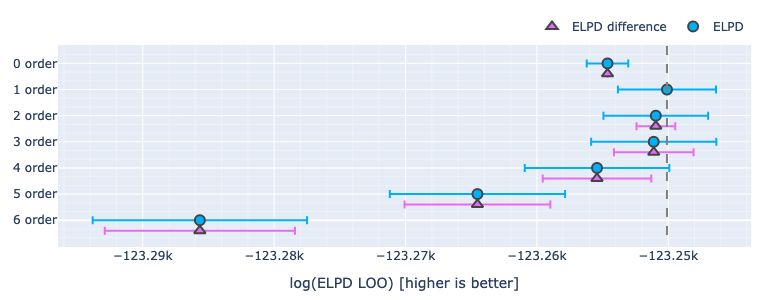

In [31]:
from leaguedata.plot import plot_compare_plotly

plot_compare_plotly(
    compare_dataframe.rename(lambda x: f'{x[0]} order'), 
    save_to='docs/loserQ/assets/true_data_compare_results_balanced.json'
);

/opt/mamba/lib/python3.12/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




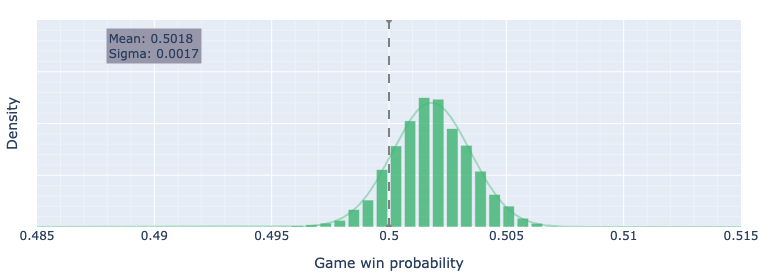

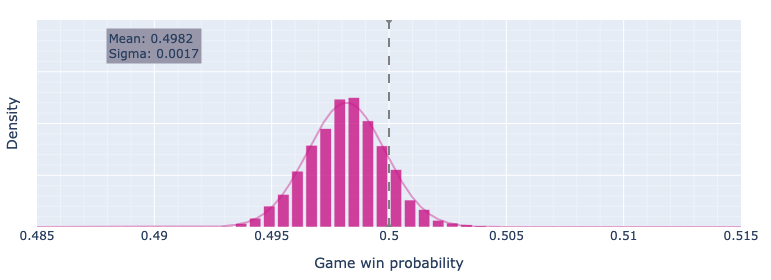

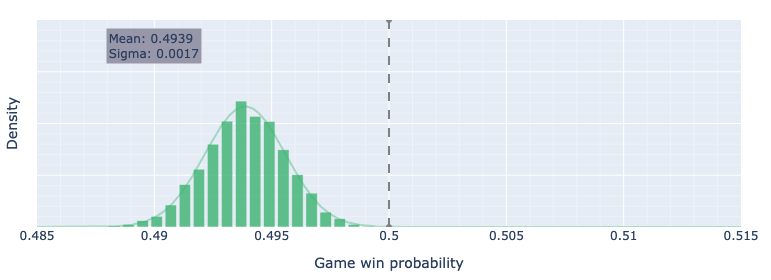

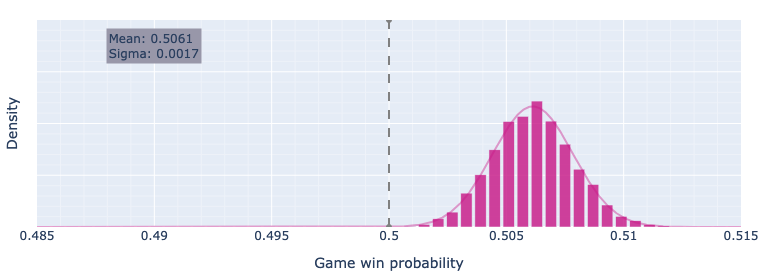

In [33]:
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import norm

best_id = dict_of_id['1 games']
results = np.asarray(az.extract(best_id).proba)
data1 = results[1] # W>W
data2 = 1 - results[1] # W>L
data3 = results[0] #L>W
data4 = 1 - results[0] #W>W

# List of data and colors
data_list = [data1, data2, data3, data4]
titles = ["Winning after winning", "Losing after winning", "Winning after losing", "Losing after losing"]
colors = ['rgba(60, 179, 113, 0.8)',  'rgba(199, 21, 133, 0.8)', 'rgba(60, 179, 113, 0.8)',  'rgba(199, 21, 133, 0.8)']  
colors_density = ['rgba(60, 179, 113, 0.4)',  'rgba(199, 21, 133, 0.4)', 'rgba(60, 179, 113, 0.4)',  'rgba(199, 21, 133, 0.4)']  
x_min, x_max = 0.485, 0.515

for i, (data, color, color_density) in enumerate(zip(data_list, colors, colors_density)):

    fig = go.Figure()#make_subplots(rows=2, cols=2, subplot_titles=titles, shared_xaxes='all', shared_yaxes='all',)
    # Compute histogram
    hist = np.histogram(data, bins=50, range=(x_min, x_max), density=True)
    bins = hist[1]
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Fit a gaussian
    mu, sigma = norm.fit(data)
    pdf = norm.pdf(np.linspace(x_min, x_max, 1000), mu, sigma)

    # Create histogram trace
    hist_trace = go.Bar(x=bin_centers, y=hist[0], showlegend=False, marker_color=color, name=f'Hist {i+1}')
    
    # Create gaussian fit trace
    fit_trace = go.Scatter(x=np.linspace(x_min, x_max, 1000), y=pdf, mode='lines', line=dict(color=color_density),
                           text=[f'Mean: {mu:.2f}<br>Sigma: {sigma:.2f}']*len(bin_centers),
                           hoverinfo='text+x+y')

    ref_trace = go.Line(
        x=[0.5, 0.5], 
        y=[0, 400], 
        line=dict(color="grey", width=2, dash="dash")
    )
    
    # Add traces to the subplot
    fig.add_trace(hist_trace)#, row=row, col=col)
    fig.add_trace(fit_trace)#, row=row, col=col)
    fig.add_trace(ref_trace)#, row=row, col=col)

    # Add annotations for mean and sigma
    annotation = dict(
        x=0.49, y=350, #xref=f'x{i+1}', yref=f'y{i+1}',
        text=f'Mean: {mu:.4f}<br>Sigma: {sigma:.4f}',
        showarrow=False, align='left', bgcolor='#9897a9'
    )
    fig.add_annotation(annotation)

    fig.update_xaxes(range=[x_min, x_max], title='Game win probability', 
        showgrid=True, minor=dict(showgrid=True))
    fig.update_yaxes(range=[0., 400.], showticklabels=False, title='Density', 
        showgrid=True, minor=dict(showgrid=True))
    #fig.update_yaxes(range=[0, 1], dtick=0.2)
    # Update layout
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        #title_text=titles[i], title_x=0.5,
        height=280, width=320, showlegend=False,
    )
    
    # Show plot
    fig.show()
    
    with open(f'docs/loserQ/assets/true_data_transition_probas_{i}.json', "w") as f:
        f.write(fig.to_json())

In [36]:
import yaml

dict_of_results = {}

titles_low = [
    "win_after_win", 
    "lose_after_win", 
    "win_after_lose", 
    "lose_after_lose"
]

for key, data in zip(titles_low, data_list):
    dict_of_results[f'{key}_mean'] = float(np.mean(data))
    dict_of_results[f'{key}_std'] = float(np.std(data))
    
with open('docs/loserQ/assets/true_data_result.yml', 'w') as file:
    yaml.dump(dict_of_results, file)